In [25]:
%matplotlib inline

import os
import numpy as np
from skimage import data, io, filters, transform
from skimage.transform import resize
import pandas as pd
import shutil
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')

# CNN to predict invasive species based on images

Follows mostly the description on:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [2]:
train_path = '.\\data\\train\\'
test_path = '.\\data\\test\\'

print('# of training files: ' + str(len(os.listdir(train_path))))
print('# of testing files: ' + str(len(os.listdir(test_path))))

# Load train labels in Data Frame
train_labels = pd.read_csv("data/train_labels.csv")

train_labels.head()

# of training files: 2297
# of testing files: 1


name  invasive
0     1         0
1     2         0
2     3         1
3     4         0
4     5         1

# Show images of invasive class

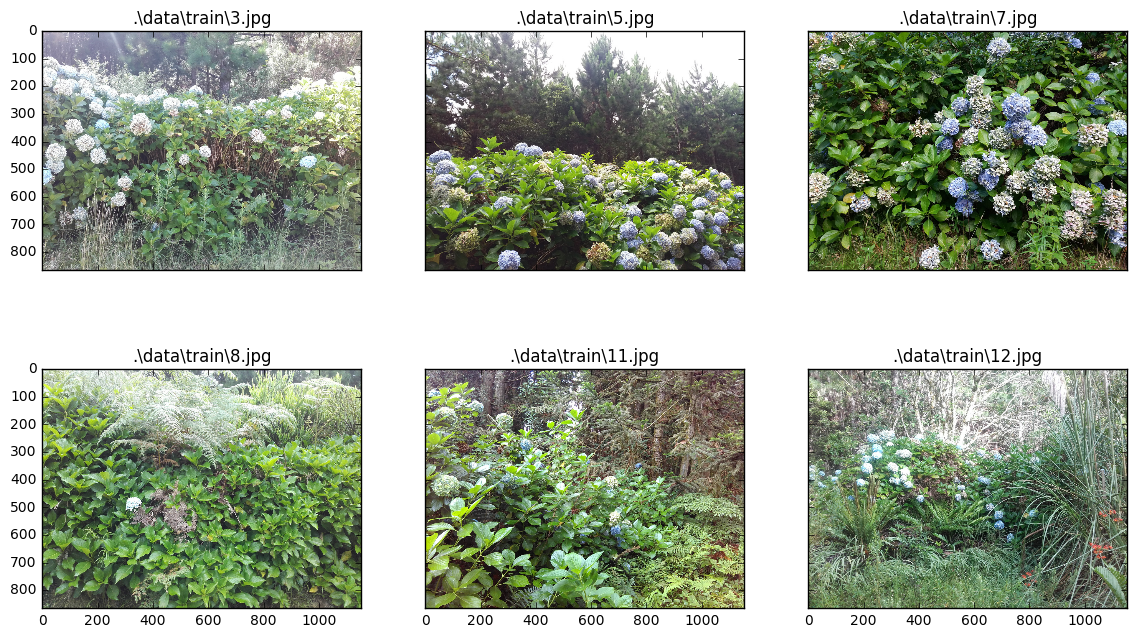

In [3]:
# Show 2x3 images of invasive class
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

for i in range(0,2):
    for j in range(0,3):
        file_id = train_labels["name"][train_labels["invasive"]==1].iloc[i*3 + j]
        file_name = ".\\data\\train\\" + str(file_id) + ".jpg"
        image = io.imread(file_name)
        axes[i,j].imshow(image)
        axes[i, j].set_title(file_name)

# Show images of non-invasive class

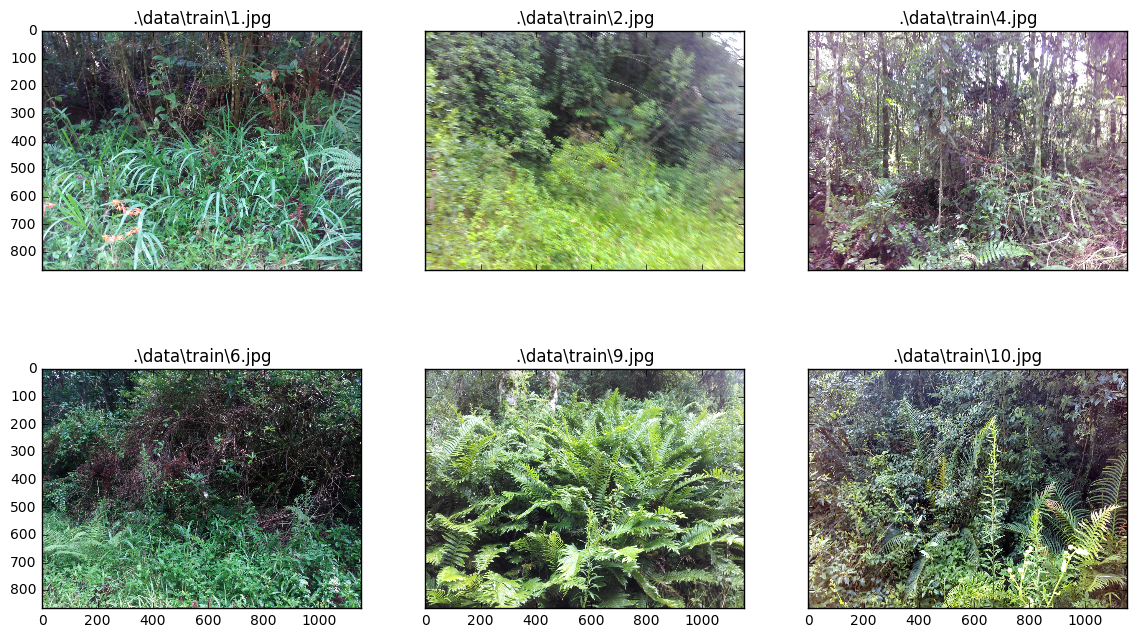

In [4]:
# Show 2x3 images of non-invasive class
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

for i in range(0,2):
    for j in range(0,3):
        file_id = train_labels["name"][train_labels["invasive"]==0].iloc[i*3 + j]
        file_name = ".\\data\\train\\" + str(file_id) + ".jpg"
        image = io.imread(file_name)
        axes[i,j].imshow(image)
        axes[i, j].set_title(file_name)

# Move data to sub folders (required for Keras)

In [5]:
# Delete subfolders including content
shutil.rmtree(".\\data\\train\\0\\")
shutil.rmtree(".\\data\\train\\1\\")
shutil.rmtree(".\\data\\val\\0\\")
shutil.rmtree(".\\data\\val\\1\\")

# Create them
if not os.path.exists(".\\data\\train\\0\\"):
    os.makedirs(".\\data\\train\\0\\")
    
if not os.path.exists(".\\data\\train\\1\\"):
    os.makedirs(".\\data\\train\\1\\")
    
if not os.path.exists(".\\data\\val\\0\\"):
    os.makedirs(".\\data\\val\\0\\")    
    
if not os.path.exists(".\\data\\val\\1\\"):
    os.makedirs(".\\data\\val\\1\\")    

In [6]:
val_fraction = 0.2

for file_id in range(0, train_labels.shape[0]):
    
    file_name = ".\\data\\train\\" + str(train_labels["name"][file_id]) + ".jpg"
    image = io.imread(file_name)
    
    if train_labels["invasive"][file_id] == 1:
        if np.random.rand() < val_fraction:
            file_name_new = ".\\data\\val\\1\\" + str(train_labels["name"][file_id]) + ".jpg"    
        else:    
            file_name_new = ".\\data\\train\\1\\" + str(train_labels["name"][file_id]) + ".jpg"    
    else:
        if np.random.rand() < val_fraction:
            file_name_new = ".\\data\\val\\0\\" + str(train_labels["name"][file_id]) + ".jpg"        
        else:
            file_name_new = ".\\data\\train\\0\\" + str(train_labels["name"][file_id]) + ".jpg"        
    
    shutil.copy(file_name, file_name_new)

# Prepare data for convolutional network

In [8]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

# Test generator
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size = 1,
        class_mode=None,
        shuffle=False)

Found 1841 images belonging to 2 classes.
Found 454 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


# Build convolutional network

In [9]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

In [11]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')

Epoch 1/5
125/125 [==============================] - 118s - loss: 0.6363 - acc: 0.6740 - val_loss: 0.4674 - val_acc: 0.7759
Epoch 2/5
125/125 [==============================] - 121s - loss: 0.4902 - acc: 0.7765 - val_loss: 0.4870 - val_acc: 0.7615
Epoch 3/5
125/125 [==============================] - 124s - loss: 0.4378 - acc: 0.8060 - val_loss: 0.3315 - val_acc: 0.8654
Epoch 4/5
125/125 [==============================] - 121s - loss: 0.3952 - acc: 0.8371 - val_loss: 0.3228 - val_acc: 0.8577
Epoch 5/5
125/125 [==============================] - 123s - loss: 0.3330 - acc: 0.8705 - val_loss: 0.2941 - val_acc: 0.8734


# Evaluate

In [17]:
score = model.evaluate_generator(validation_generator, steps = 100)

In [18]:
print(score[1])

0.873717948565


# Predict

In [19]:
test_predictions = model.predict_generator(test_generator, test_generator.n, verbose=1)

1530/1531 [============================>.] - ETA: 0s

In [20]:
name = list()
for name_str in test_generator.filenames:
    name_str=name_str[5:-4]
    name.append(int(name_str))

In [21]:
prediction_results = pd.DataFrame(name, columns=["name"])

In [22]:
prediction_results["invasive"] = test_predictions

In [23]:
prediction_results.sort("name", inplace=True)

In [24]:
prediction_results.to_csv("data\\Submission_2-2017.05.21.csv", index = False)